In [5204]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from config import api_key
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
%matplotlib inline

In [5205]:
quandl.ApiConfig.api_key = api_key
#Variance Risk Premium: https://sites.google.com/site/haozhouspersonalhomepage
#EOM Nominal S&P, Nominal Dividends / Nominal Risk Free Rate: http://www.hec.unil.ch/agoyal/
#Consumer Sentiment: http://www.sca.isr.umich.edu/

In [5206]:
ticker = 'SPY'
transform = 'normalize'
start_date = '1989-01-01'
end_date = '2018-01-01'

In [5207]:
index_data = quandl.get('EOD/' + ticker, start_date=start_date, end_date=end_date, column_index=4, collapse='monthly')

In [5208]:
risk_free_rate = quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date, collapse='monthly')

In [5209]:
fed_funds_rate = quandl.get('FRED/FEDFUNDS', start_date=start_date, end_date=end_date, collapse='monthly')

In [5210]:
index_data = index_data.reset_index()
risk_free_rate = risk_free_rate.reset_index()
fed_funds_rate = fed_funds_rate.reset_index()

In [5211]:
#Calculate Monthly FFR
fed_funds_rate_list = []

for i in range(len(fed_funds_rate)):
    x = (fed_funds_rate.iloc[i]['Value']/12)/100
    fed_funds_rate_list.append(x)

In [5212]:
"""
Monthly >>>
Index: S&P 500 Index Data
D12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index (Goyal, Welch) 
     -- Confirmed with Y Charts
Rfree: Nominal Risk Free Rate
"""
goyal = pd.read_excel('PredictorData2017.xlsx')
df = pd.DataFrame(goyal)
df.tail()

'\nMonthly >>>\nIndex: S&P 500 Index Data\nD12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index (Goyal, Welch) \n     -- Confirmed with Y Charts\nRfree: Nominal Risk Free Rate\n'

,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
1759,201708,2471.649902,47.855075,106.060000,0.265114,0.0101,0.0363,0.0431,0.0242,-0.012138,0.000842,0.002994,0.0289,0.0153,0.000753,NaN,0.002238,-0.000324
1760,201709,2519.360107,48.173103,107.080000,0.259706,0.0103,0.0363,0.0430,0.0259,-0.011027,0.000858,0.005295,-0.0205,-0.0037,0.000251,NaN,0.020050,0.018742
1761,201710,2575.260010,48.426075,108.013333,0.248906,0.0107,0.0360,0.0432,0.0261,-0.012358,0.000892,-0.000632,-0.0013,0.0076,0.000224,NaN,0.024158,0.023006
1762,201711,2584.840088,48.679047,108.946667,0.239727,0.0123,0.0357,0.0427,0.0260,-0.012243,0.001025,0.000024,0.0036,0.0020,0.000361,NaN,0.031388,0.028860
1763,201712,2673.610107,48.932019,109.880000,0.235393,0.0132,0.0351,0.0422,0.0254,-0.019946,0.001100,-0.000588,0.0102,0.0256,0.000239,NaN,0.011148,0.009850


In [5213]:
#New DF with cleaned up Columns
df_cols = ['yyyymm', 'Index', 'D12', 'Rfree']
df = df[df_cols]

In [5214]:
#Convert yyyymm to Datetime then to Period
yyyymm = pd.to_datetime(df['yyyymm'], format='%Y%m').dt.strftime('%Y-%m')
periods = pd.to_datetime(yyyymm, format='%Y-%m')
df['yyyymm'] = periods

In [5215]:
df.head()
df.tail()
df.info()

,yyyymm,Index,D12,Rfree
0,1871-01-01,4.44,0.26,0.004955
1,1871-02-01,4.50,0.26,0.004514
2,1871-03-01,4.61,0.26,0.004243
3,1871-04-01,4.74,0.26,0.004632
4,1871-05-01,4.86,0.26,0.003691


,yyyymm,Index,D12,Rfree
1759,2017-08-01,2471.649902,47.855075,0.000842
1760,2017-09-01,2519.360107,48.173103,0.000858
1761,2017-10-01,2575.260010,48.426075,0.000892
1762,2017-11-01,2584.840088,48.679047,0.001025
1763,2017-12-01,2673.610107,48.932019,0.001100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 4 columns):
yyyymm    1764 non-null datetime64[ns]
Index     1764 non-null float64
D12       1764 non-null float64
Rfree     1764 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 55.2 KB


In [5216]:
#Drop rows prior to 1990-01
df = df[df['yyyymm'] >= '1990-01']

In [5217]:
df.head()
df.tail()
df.shape

,yyyymm,Index,D12,Rfree
1428,1990-01-01,329.08,11.142667,0.006367
1429,1990-02-01,331.89,11.230333,0.006450
1430,1990-03-01,339.94,11.318000,0.006583
1431,1990-04-01,330.80,11.433000,0.006475
1432,1990-05-01,361.23,11.548000,0.006450


,yyyymm,Index,D12,Rfree
1759,2017-08-01,2471.649902,47.855075,0.000842
1760,2017-09-01,2519.360107,48.173103,0.000858
1761,2017-10-01,2575.260010,48.426075,0.000892
1762,2017-11-01,2584.840088,48.679047,0.001025
1763,2017-12-01,2673.610107,48.932019,0.001100


(336, 4)

In [5218]:
"""
VRP: Variance Risk Premium = IV - RV
IV: Implied Variance = VIX-Squared/12
RV: Realized Variance = Sum of Squared 5-minute log returns of the S&P 500 Index
"""
vrp = pd.read_fwf('VRPtable.txt')
df_vrp = pd.DataFrame(vrp)
df_vrp.tail(10)
df_vrp.shape

'\nVRP: Variance Risk Premium = IV - RV\nIV: Implied Variance = VIX-Squared/12\nRV: Realized Variance = Sum of Squared 5-minute log returns of the S&P 500 Index\n'

,Year,Month,VRP,EVRP,IV,RV,ERV
338,2018,3,8.6653,5.7620,33.2334,24.5681,27.4714
339,2018,4,-1.9751,-8.2494,21.1471,23.1221,29.3964
340,2018,5,9.4048,3.2582,19.8404,10.4356,16.5822
341,2018,6,13.2745,5.0526,21.5740,8.2995,16.5214
342,2018,7,8.1409,-4.8897,13.7174,5.5765,18.6072
343,2018,8,8.5030,3.3157,13.7816,5.2786,10.4659
344,2018,9,7.9528,1.6749,12.2412,4.2884,10.5663
345,2018,10,-2.2509,28.5411,37.5594,39.8103,9.0183
346,2018,11,2.7329,-5.2160,27.2104,24.4775,32.4264
347,2018,12,-4.0034,30.9039,53.8480,57.8514,22.9441


(348, 7)

In [5219]:
#Drop 2018 Rows
df_vrp = df_vrp[df_vrp['Year'] < 2018]

In [5220]:
df_vrp.head()
df_vrp.tail()
df_vrp.shape

,Year,Month,VRP,EVRP,IV,RV,ERV
0,1990,1,35.9054,35.9054,53.5941,17.6888,17.6888
1,1990,2,32.9177,15.4492,40.2967,7.3790,24.8475
2,1990,3,26.5978,16.0745,32.4394,5.8416,16.3649
3,1990,4,26.2753,18.6211,31.7525,5.4773,13.1314
4,1990,5,19.2201,12.3841,25.1431,5.9229,12.7589


,Year,Month,VRP,EVRP,IV,RV,ERV
331,2017,8,4.5638,5.2881,9.3457,4.7819,4.0576
332,2017,9,4.9171,2.5581,7.5367,2.6196,4.9786
333,2017,10,6.5894,5.1081,8.6360,2.0466,3.5279
334,2017,11,6.9722,6.9307,10.6032,3.6310,3.6725
335,2017,12,6.1073,5.2063,10.1568,4.0495,4.9505


(336, 7)

In [5221]:
#Drop Unnecessary Columns
df_vrp = df_vrp[['VRP']]

In [5222]:
df_vrp.head()

,VRP
0,35.9054
1,32.9177
2,26.5978
3,26.2753
4,19.2201


In [5223]:
df = pd.concat([df.reset_index(drop=True), df_vrp.reset_index(drop=True)], axis=1)
df.head()

,yyyymm,Index,D12,Rfree,VRP
0,1990-01-01,329.08,11.142667,0.006367,35.9054
1,1990-02-01,331.89,11.230333,0.006450,32.9177
2,1990-03-01,339.94,11.318000,0.006583,26.5978
3,1990-04-01,330.80,11.433000,0.006475,26.2753
4,1990-05-01,361.23,11.548000,0.006450,19.2201


In [5224]:
#Rename yyyymm Column to EOM
df = df.rename(columns={'yyyymm': 'EOM'})

In [5225]:
#New DF from Index / Div / Rfree Data -> Need to Add 1989 Data.
df_1989 = pd.DataFrame(goyal)
df_1989_cols = ['yyyymm', 'Index', 'D12', 'Rfree']
df_1989 = df_1989[df_1989_cols]
yyyymm_1989 = pd.to_datetime(df_1989['yyyymm'], format='%Y%m').dt.strftime('%Y-%m')
periods_1989 = pd.to_datetime(yyyymm_1989, format='%Y-%m')
df_1989['yyyymm'] = periods_1989
df_1989 = df_1989[(df_1989['yyyymm'] >= '1989-01') & (df_1989['yyyymm'] < '1990-01')]
df_1989

,yyyymm,Index,D12,Rfree
1416,1989-01-01,297.47,9.837,0.006892
1417,1989-02-01,288.86,9.924,0.007108
1418,1989-03-01,294.87,10.011,0.007350
1419,1989-04-01,309.64,10.130,0.007208
1420,1989-05-01,320.52,10.249,0.007025
1421,1989-06-01,317.98,10.368,0.006792
1422,1989-07-01,346.08,10.490,0.006567
1423,1989-08-01,351.45,10.612,0.006583
1424,1989-09-01,349.15,10.734,0.006458
1425,1989-10-01,340.36,10.841,0.006367


In [5226]:
df_1989 = df_1989.rename(columns={'yyyymm': 'EOM'})
df_1989

,EOM,Index,D12,Rfree
1416,1989-01-01,297.47,9.837,0.006892
1417,1989-02-01,288.86,9.924,0.007108
1418,1989-03-01,294.87,10.011,0.007350
1419,1989-04-01,309.64,10.130,0.007208
1420,1989-05-01,320.52,10.249,0.007025
1421,1989-06-01,317.98,10.368,0.006792
1422,1989-07-01,346.08,10.490,0.006567
1423,1989-08-01,351.45,10.612,0.006583
1424,1989-09-01,349.15,10.734,0.006458
1425,1989-10-01,340.36,10.841,0.006367


In [5227]:
df = pd.concat([df_1989, df], axis=0, ignore_index=True, sort=False)

In [5228]:
"""
Get monthly average Federal Funds Rate:
https://fred.stlouisfed.org/series/FEDFUNDS
***Is this divided by 12?***
"""
fed_funds_file = pd.read_csv('FEDFUNDS (1).csv')
fed_funds = pd.DataFrame(fed_funds_file)
fed_funds.head()

'\nGet monthly average Federal Funds Rate:\nhttps://fred.stlouisfed.org/series/FEDFUNDS\n***Is this divided by 12?***\n'

,DATE,FEDFUNDS
0,1989-01-01,9.12
1,1989-02-01,9.36
2,1989-03-01,9.85
3,1989-04-01,9.84
4,1989-05-01,9.81


In [5229]:
fed_funds['FEDFUNDS'] = (fed_funds['FEDFUNDS'])

In [5230]:
fed_funds = fed_funds['FEDFUNDS']
df = pd.concat([df.reset_index(drop=True), fed_funds.reset_index(drop=True)], axis=1)
df = df.rename(columns={'FEDFUNDS': 'fed_funds'})

In [5231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 6 columns):
EOM          348 non-null datetime64[ns]
Index        348 non-null float64
D12          348 non-null float64
Rfree        348 non-null float64
VRP          336 non-null float64
fed_funds    348 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 16.4 KB


In [5232]:
sentiment_file = 'tbmics.csv'
sentiment = pd.read_csv(sentiment_file)
sentiment.head(10)

,Month,YYYY,ICS_ALL
0,November,1952,86.2
1,February,1953,90.7
2,August,1953,80.8
3,November,1953,80.7
4,February,1954,82.0
5,May,1954,82.9
6,November,1954,87.0
7,February,1955,95.9
8,May,1955,99.1
9,November,1955,99.7


In [5233]:
sentiment = sentiment[(sentiment['YYYY'] >= 1989) & (sentiment['YYYY'] < 2018)]
sentiment = sentiment['ICS_ALL']

In [5234]:
df = pd.concat([df.reset_index(drop=True), sentiment.reset_index(drop=True)], axis=1)

In [5235]:
"""
FORMULAS:

Two Gross Nominal Return Formulas. Paper defines Gross Nominal Return as:
(P_t + (D_t / 12)) / P_t-1) --> Not Standard formula, results in 1.011383, is this intentional?

"""

#Number of Periods in Variance Risk Premium
vrp_rolling_periods = 3

#Calculate Gross Nominal Return
#gross_nominal_return_1 = ((df['Index'] + (df['D12'] / 12)) - df['Index'].shift(1)) / df['Index'].shift(1)
#gross_nominal_return_2 = ((df['Index'] + df['D12'] / 12))/ df['Index'].shift(1) - 1

#Calculate Price Dividend Ratio
price_dividend_ratio = (df['Index'] / df['D12'])

#Calculate Fed Funds Rate Delta
fed_funds_delta_formula = df['fed_funds'] - df['fed_funds'].shift(12)

#Calculate Variance Risk Premium Rolling
rolling_vrp_formula = df['VRP'].rolling(vrp_rolling_periods).mean()

#Calculate Sentiment Delta
sent_delta_formula = (df['ICS_ALL'] - df['ICS_ALL'].shift(shift_var + 12));

In [5236]:
#Create Column with Gross Nominal Return
#df['g_nominal_return'] = gross_nominal_return_1

#Create Column with PD Ratio
df['pd'] = price_dividend_ratio

#Create Column with Fed Funds Rate Delta (12 Month)
df['ff12_D'] = fed_funds_delta_formula

#Create Column with Rolling Variance Risk Premium Rolling
df['vrp3'] = rolling_vrp_formula

#Create Column with Sentiment Delta
df['sent12_D'] = sent_delta_formula

#Create Column with Excess Return on Index Relative to the RFR in percent
df['ersf'] = (((df['Index'] + df['D12']/12 - df['Index'].shift(1)) / df['Index'].shift(1)) - df['Rfree']) * 100

#Create Column with Excess Return on Index Relative to the RFR in percent
df['ersf_t1'] = (((df['Index'].shift(-1) + df['D12'].shift(-1)/12 - df['Index']) / df['Index']) - df['Rfree'].shift(-1)) * 100

#Create Column with 1-month Delta in ersf
df['ersf_D'] = df['ersf'] - df['ersf'].shift(1)

#Create column with Sentiment X ersf Delta
df['sent_x_ersf_D'] = df['sent12_D'] * df['ersf_D']

In [5237]:
#Create Filter for 1990 and Later
filt_1990 = (df['EOM'] >= '1990-03') & (df['EOM'] < '2018-01')
dfx = df[filt_1990]

In [5238]:
#Fill the NaN value on the Target Variable with the Mean
dfx.fillna(dfx.mean(), inplace=True)
dfx.tail(12)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
336,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.65,98.5,49.618451,0.31,8.796700,6.5,1.916891,3.845262,-0.033886,-0.220260
337,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.66,96.3,51.210751,0.28,10.313433,4.6,3.845262,0.062941,1.928371,8.870506
338,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.79,96.9,50.939985,0.43,8.532733,5.9,0.062941,1.007029,-3.782321,-22.315693
339,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.90,97.0,51.095887,0.53,7.542033,8.0,1.007029,1.247525,0.944088,7.552702
340,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.91,97.1,51.380318,0.54,5.797533,2.4,1.247525,0.562864,0.240496,0.577191
341,2017-06-01,2423.409912,47.219019,0.000817,5.9955,1.04,95.0,51.322750,0.66,5.397200,1.5,0.562864,2.009181,-0.684662,-1.026992
342,2017-07-01,2470.300049,47.537047,0.000892,5.8568,1.15,93.4,51.965786,0.76,5.851800,3.4,2.009181,0.131911,1.446317,4.917478
343,2017-08-01,2471.649902,47.855075,0.000842,4.5638,1.16,96.8,51.648647,0.76,5.472033,7.0,0.131911,2.006883,-1.877269,-13.140885
344,2017-09-01,2519.360107,48.173103,0.000858,4.9171,1.15,95.1,52.298066,0.75,5.112567,3.9,2.006883,2.289827,1.874972,7.312391
345,2017-10-01,2575.260010,48.426075,0.000892,6.5894,1.15,100.7,53.179202,0.75,5.356767,13.5,2.289827,0.427026,0.282943,3.819735


In [5239]:
dfx.describe()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,1163.313893,22.396469,0.002270,17.307943,2.937904,86.840719,52.045820,-0.289132,17.390332,0.176347,0.658096,0.653912,0.008948,-3.635747
std,543.692853,10.218236,0.001883,13.929337,2.408457,12.484535,14.204175,1.405820,11.135081,10.053697,4.100433,4.099720,5.683893,57.413770
min,304.000000,11.318000,0.000008,-9.724000,0.070000,55.300000,25.507636,-4.580000,3.052700,-30.000000,-16.793245,-16.793245,-13.574290,-294.411915
25%,764.380000,15.019000,0.000179,8.354675,0.225000,77.600000,44.239881,-0.757500,9.454383,-4.250000,-1.668809,-1.668809,-3.672094,-18.127597
50%,1158.590000,17.704500,0.002408,13.408600,3.000000,88.950000,51.087280,-0.030000,13.623633,1.100000,1.022578,1.011573,-0.036734,-0.231316
75%,1415.175000,27.594417,0.004115,23.482400,5.250000,94.925000,58.380221,0.297500,23.211900,6.500000,3.324716,3.324716,3.327125,13.259903
max,2673.610107,48.932019,0.006583,80.610800,8.290000,112.000000,92.170533,2.670000,59.880367,22.800000,11.090639,11.090639,20.864358,279.621622


In [5240]:
dfx.corr()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
Index,1.000000,0.902141,-0.549448,-0.254825,-0.527675,0.173381,0.405512,0.260710,-0.305007,0.118145,0.045316,-0.034468,0.001832,0.040746
D12,0.902141,1.000000,-0.666138,-0.267992,-0.649351,-0.104491,-0.016092,0.155327,-0.340338,0.098251,0.016986,0.017907,0.003475,0.025727
Rfree,-0.549448,-0.666138,1.000000,0.102202,0.995661,0.427237,0.072414,0.144739,0.119237,-0.138734,-0.017698,-0.024019,-0.009751,0.012278
VRP,-0.254825,-0.267992,0.102202,1.000000,0.112788,-0.087792,0.045263,-0.303380,0.798353,-0.186667,-0.235717,0.151780,-0.111396,-0.047591
fed_funds,-0.527675,-0.649351,0.995661,0.112788,1.000000,0.414117,0.090527,0.123847,0.133474,-0.174604,-0.023561,-0.026598,-0.006417,0.003342
ICS_ALL,0.173381,-0.104491,0.427237,-0.087792,0.414117,1.000000,0.588048,0.417148,-0.108570,0.413256,0.047155,-0.004110,-0.060053,0.048127
pd,0.405512,-0.016092,0.072414,0.045263,0.090527,0.588048,1.000000,0.204664,0.086752,0.029760,0.032415,-0.116647,-0.001570,0.029592
ff12_D,0.260710,0.155327,0.144739,-0.303380,0.123847,0.417148,0.204664,1.000000,-0.360951,0.350276,0.129061,0.139231,-0.000043,0.039779
vrp3,-0.305007,-0.340338,0.119237,0.798353,0.133474,-0.108570,0.086752,-0.360951,1.000000,-0.206029,0.040064,0.211080,0.077389,-0.167591
sent12_D,0.118145,0.098251,-0.138734,-0.186667,-0.174604,0.413256,0.029760,0.350276,-0.206029,1.000000,0.170626,0.097862,-0.063843,0.052724


In [5308]:
lr_model= ols(formula='ersf_t1~pd+ff12_D+vrp3+sent_x_ersf_D', data=dfx).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ersf_t1   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     17.47
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           5.21e-13
Time:                        13:59:11   Log-Likelihood:                -912.51
No. Observations:                 334   AIC:                             1835.
Df Residuals:                     329   BIC:                             1854.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8879      0.828      2.280      0.023       0.259       3.517
pd               -0.0571      0.015     -3.802      0.000      -0.087      -0.028
ff12_D            0.8653      0.162      5.342      0.000       0.547       1.184
vrp3              0.1114      0.020      5.467      0.000       0.071       0.152
sent_x_ersf_D    -0.0139      0.004     -3.840      0.000      -0.021      -0.007
==============================================================================
Omnibus:                       29.981   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.684
Skew:                          -0.656   Prob(JB):                     2.41e-09
Kurtosis:                       4.063   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

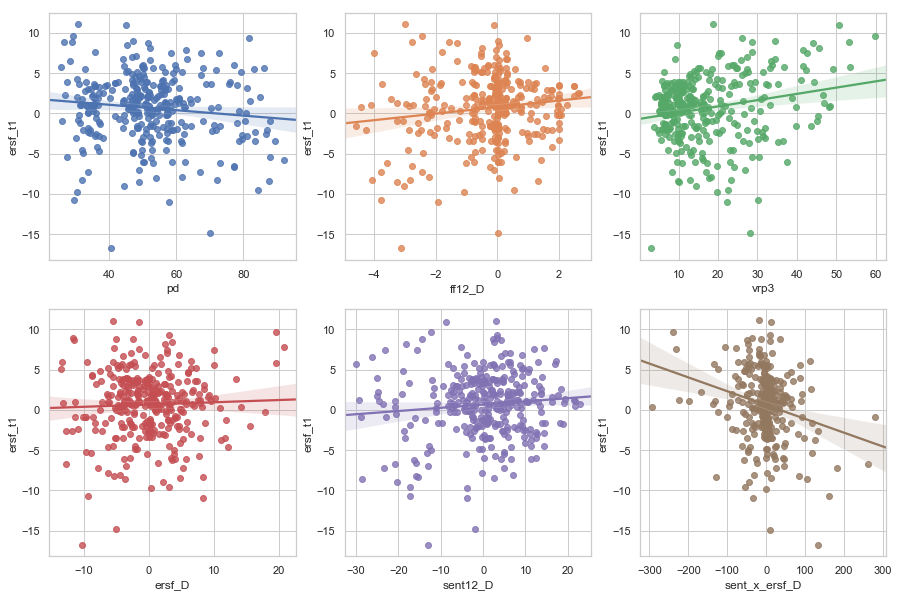

In [5296]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(15, 10))
sns.set(style='whitegrid', palette='deep')

sns.regplot(x='pd', y='ersf_t1', data=dfx, ax=axs[0,0])
sns.regplot(x='ff12_D', y='ersf_t1', data=dfx, ax=axs[0,1])
sns.regplot(x='vrp3', y='ersf_t1', data=dfx, ax=axs[0,2])
sns.regplot(x='ersf_D', y='ersf_t1', data=dfx, ax=axs[1,0])
sns.regplot(x='sent12_D', y='ersf_t1', data=dfx, ax=axs[1,1])
sns.regplot(x='sent_x_ersf_D', y='ersf_t1', data=dfx, ax=axs[1,2]);

In [5324]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

ind_variables = ['pd', 'ff12_D', 'vrp3', 'sent_x_ersf_D']
X = pd.DataFrame(dfx, columns=ind_variables)
y = pd.DataFrame(dfx, columns=['ersf_t1'])

lm = linear_model.LinearRegression(normalize=True)
model = lm.fit(X,y)

In [5404]:
predictions = model.predict(X)
print(predictions[0:5])

[[ 4.12986801]
 [ 4.85465694]
 [ 0.83205935]
 [-5.07402728]
 [-0.07390654]]


In [5402]:
y.head()

,ersf_t1
14,-3.055940
15,8.844823
16,-1.263740
17,-0.884521
18,-9.776690


In [5403]:
X.head()

,pd,ff12_D,vrp3,sent_x_ersf_D
14,30.035342,-1.57,31.806967,-4.674200
15,28.933788,-1.58,28.596933,-12.257494
16,31.280741,-1.63,24.031067,-1.190076
17,30.697076,-1.24,19.525000,23.249693
18,30.388225,-1.09,19.762233,-1.441033


In [5326]:
lm.score(X,y), lm.coef_, lm.intercept_

(0.17516180906851953,
 array([[-0.05710409,  0.86531069,  0.11141535, -0.01394749]]),
 array([1.88787084]))

In [5312]:
df_to_scale = dfx.drop(columns=['EOM'])
df_to_scale.head()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
14,339.94,11.318,0.006583,26.5978,8.28,91.3,30.035342,-1.57,31.806967,-3.0,2.051350,-3.055940,1.558067,-4.674200
15,330.80,11.433,0.006475,26.2753,8.26,93.9,28.933788,-1.58,28.596933,2.4,-3.055940,8.844823,-5.107289,-12.257494
16,361.23,11.548,0.006450,19.2201,8.18,90.6,31.280741,-1.63,24.031067,-0.1,8.844823,-1.263740,11.900762,-1.190076
17,358.02,11.663,0.006442,13.0796,8.29,88.3,30.697076,-1.24,19.525000,-2.3,-1.263740,-0.884521,-10.108562,23.249693
18,356.15,11.720,0.006350,26.9870,8.15,88.2,30.388225,-1.09,19.762233,-3.8,-0.884521,-9.776690,0.379219,-1.441033


In [5313]:
cols = df_to_scale.columns.to_list()

scaled_dfx = scaler.fit_transform(df_to_scale)
scaled_df = pd.DataFrame(scaled_dfx, columns=cols)

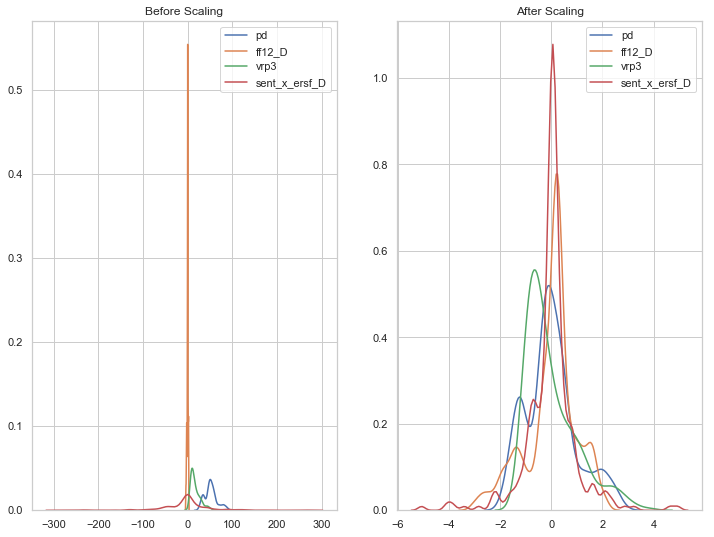

In [5302]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 9))

ax1.set_title('Before Scaling')
sns.kdeplot(dfx['pd'], ax=ax1)
sns.kdeplot(dfx['ff12_D'], ax=ax1)
sns.kdeplot(dfx['vrp3'], ax=ax1)
sns.kdeplot(dfx['sent_x_ersf_D'], ax=ax1)

ax2.set_title('After Scaling')
sns.kdeplot(scaled_df['pd'], ax=ax2)
sns.kdeplot(scaled_df['ff12_D'], ax=ax2)
sns.kdeplot(scaled_df['vrp3'], ax=ax2)
sns.kdeplot(scaled_df['sent_x_ersf_D'], ax=ax2)
plt.show();

In [5327]:
ind_variables = ['pd', 'ff12_D', 'vrp3', 'sent_x_ersf_D']
Xx = pd.DataFrame(scaled_df, columns=ind_variables)
yy = pd.DataFrame(scaled_df, columns=['ersf_t1'])

lm_scaled = linear_model.LinearRegression()
model = lm_scaled.fit(Xx,yy)

In [5407]:
lm_scaled.score(Xx,yy), lm_scaled.coef_, lm_scaled.intercept_

(0.17516180906851953,
 array([[-0.19784682,  0.29672057,  0.30261067, -0.19532509]]),
 array([-2.62150177e-17]))

In [5368]:
dfx.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
14,1990-03-01,339.94,11.318,0.006583,26.5978,8.28,91.3,30.035342,-1.57,31.806967,-3.0,2.051350,-3.055940,1.558067,-4.674200
15,1990-04-01,330.80,11.433,0.006475,26.2753,8.26,93.9,28.933788,-1.58,28.596933,2.4,-3.055940,8.844823,-5.107289,-12.257494
16,1990-05-01,361.23,11.548,0.006450,19.2201,8.18,90.6,31.280741,-1.63,24.031067,-0.1,8.844823,-1.263740,11.900762,-1.190076
17,1990-06-01,358.02,11.663,0.006442,13.0796,8.29,88.3,30.697076,-1.24,19.525000,-2.3,-1.263740,-0.884521,-10.108562,23.249693
18,1990-07-01,356.15,11.720,0.006350,26.9870,8.15,88.2,30.388225,-1.09,19.762233,-3.8,-0.884521,-9.776690,0.379219,-1.441033


In [5383]:
google_trends_file = 'multiTimeline.csv'

google_data = pd.read_csv(google_trends_file)
google = pd.DataFrame(google_data)

In [5384]:
google = google[1:]

In [5386]:
google.shape

(168, 1)

In [5387]:
#Create Filter for 2004 and Later
filt_2004 = (df['EOM'] >= '2004-01-01') & (df['EOM'] < '2018-01-01')
df04 = df[filt_2004]

#Fill the NaN value on the Target Variable with the Mean
df04.fillna(df04.mean(), inplace=True)
df04.tail(12)

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D
336,2017-01-01,2278.870117,45.927877,0.000425,7.4651,0.65,98.5,49.618451,0.31,8.796700,6.5,1.916891,3.845262,-0.033886,-0.220260
337,2017-02-01,2363.639893,46.155150,0.000433,10.9366,0.66,96.3,51.210751,0.28,10.313433,4.6,3.845262,0.062941,1.928371,8.870506
338,2017-03-01,2362.719971,46.382424,0.000617,7.1965,0.79,96.9,50.939985,0.43,8.532733,5.9,0.062941,1.007029,-3.782321,-22.315693
339,2017-04-01,2384.199951,46.661289,0.000667,4.4930,0.90,97.0,51.095887,0.53,7.542033,8.0,1.007029,1.247525,0.944088,7.552702
340,2017-05-01,2411.800049,46.940154,0.000742,5.7031,0.91,97.1,51.380318,0.54,5.797533,2.4,1.247525,0.562864,0.240496,0.577191
341,2017-06-01,2423.409912,47.219019,0.000817,5.9955,1.04,95.0,51.322750,0.66,5.397200,1.5,0.562864,2.009181,-0.684662,-1.026992
342,2017-07-01,2470.300049,47.537047,0.000892,5.8568,1.15,93.4,51.965786,0.76,5.851800,3.4,2.009181,0.131911,1.446317,4.917478
343,2017-08-01,2471.649902,47.855075,0.000842,4.5638,1.16,96.8,51.648647,0.76,5.472033,7.0,0.131911,2.006883,-1.877269,-13.140885
344,2017-09-01,2519.360107,48.173103,0.000858,4.9171,1.15,95.1,52.298066,0.75,5.112567,3.9,2.006883,2.289827,1.874972,7.312391
345,2017-10-01,2575.260010,48.426075,0.000892,6.5894,1.15,100.7,53.179202,0.75,5.356767,13.5,2.289827,0.427026,0.282943,3.819735


In [5388]:
df04.shape

(168, 15)

In [5389]:
df04 = pd.concat([df04.reset_index(drop=True), google.reset_index(drop=True)], axis=1)

In [5390]:
df04 = df04.rename(columns={'Category: All categories': 'Google'})

In [5393]:
df04['Google'] = df04['Google'].astype('float64')

In [5394]:
df04.dtypes

EOM              datetime64[ns]
Index                   float64
D12                     float64
Rfree                   float64
VRP                     float64
fed_funds               float64
ICS_ALL                 float64
pd                      float64
ff12_D                  float64
vrp3                    float64
sent12_D                float64
ersf                    float64
ersf_t1                 float64
ersf_D                  float64
sent_x_ersf_D           float64
Google                  float64
dtype: object

In [5412]:
df04["Google_D"] = df04['Google'] - df04['Google'].shift(1)
df04.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2004-01-01,1131.13,17.598000,0.000733,14.0860,1.00,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,27.0,NaN
1,2004-02-01,1144.94,17.811000,0.000775,9.8728,1.01,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,27.0,0.0
2,2004-03-01,1126.21,18.024000,0.000783,9.4462,1.00,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,27.0,0.0
3,2004-04-01,1107.30,18.216667,0.000783,13.4427,1.00,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-2.0
4,2004-05-01,1120.68,18.409333,0.000850,5.2403,1.00,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,21.0,-4.0


In [5413]:
df04.fillna(df04.mean(), inplace=True)
df04.head()

,EOM,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2004-01-01,1131.13,17.598000,0.000733,14.0860,1.00,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,27.0,0.023952
1,2004-02-01,1144.94,17.811000,0.000775,9.8728,1.01,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,27.0,0.000000
2,2004-03-01,1126.21,18.024000,0.000783,9.4462,1.00,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,27.0,0.000000
3,2004-04-01,1107.30,18.216667,0.000783,13.4427,1.00,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-2.000000
4,2004-05-01,1120.68,18.409333,0.000850,5.2403,1.00,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,21.0,-4.000000


In [5414]:
df04.corr()

,Index,D12,Rfree,VRP,fed_funds,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
Index,1.000000,0.926910,-0.197435,-0.377489,-0.189128,0.579347,0.091090,0.240900,-0.460633,0.233288,0.131134,0.020015,0.004965,0.056154,0.043981,0.030778
D12,0.926910,1.000000,-0.372532,-0.198381,-0.355154,0.361418,-0.283143,-0.030664,-0.265411,0.135172,0.042347,0.045339,0.014146,0.025965,0.197457,0.017756
Rfree,-0.197435,-0.372532,1.000000,-0.270263,0.991658,0.267316,0.477579,0.422660,-0.363454,-0.243364,-0.069381,-0.089303,-0.019006,0.050823,-0.092243,0.028209
VRP,-0.377489,-0.198381,-0.270263,1.000000,-0.268302,-0.483545,-0.468140,-0.371260,0.769026,-0.060501,-0.240775,0.210191,-0.122761,0.018431,0.021218,-0.094944
fed_funds,-0.189128,-0.355154,0.991658,-0.268302,1.000000,0.230430,0.448993,0.357401,-0.355477,-0.281639,-0.088243,-0.109466,-0.018672,0.047813,-0.068897,0.034335
ICS_ALL,0.579347,0.361418,0.267316,-0.483545,0.230430,1.000000,0.582132,0.635770,-0.599270,0.489859,0.109358,0.047514,-0.062101,0.015227,-0.082560,0.029741
pd,0.091090,-0.283143,0.477579,-0.468140,0.448993,0.582132,1.000000,0.706587,-0.512646,0.231991,0.195010,-0.075350,-0.030940,0.068783,-0.363363,0.032379
ff12_D,0.240900,-0.030664,0.422660,-0.371260,0.357401,0.635770,0.706587,1.000000,-0.418635,0.347842,0.212527,0.195731,-0.012541,0.034151,-0.338423,0.023657
vrp3,-0.460633,-0.265411,-0.363454,0.769026,-0.355477,-0.599270,-0.512646,-0.418635,1.000000,-0.004952,0.072134,0.294579,0.087702,-0.130402,0.047011,-0.046225
sent12_D,0.233288,0.135172,-0.243364,-0.060501,-0.281639,0.489859,0.231991,0.347842,-0.004952,1.000000,0.267856,0.197344,-0.049284,-0.064181,-0.233304,0.000506


In [5416]:
lr04_model= ols(formula='ersf_t1~pd+ff12_D+vrp3+sent_x_ersf_D+Google_D', data=df04).fit()
lr04_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ersf_t1   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     15.25
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           2.87e-12
Time:                        14:59:08   Log-Likelihood:                -433.53
No. Observations:                 168   AIC:                             879.1
Df Residuals:                     162   BIC:                             897.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2808      3.087      2.035      0.044       0.185      12.376
pd               -0.1482      0.057     -2.583      0.011      -0.261      -0.035
ff12_D            1.6502      0.284      5.813      0.000       1.090       2.211
vrp3              0.1402      0.029      4.758      0.000       0.082       0.198
sent_x_ersf_D    -0.0084      0.005     -1.849      0.066      -0.017       0.001
Google_D         -0.0889      0.027     -3.284      0.001      -0.142      -0.035
==============================================================================
Omnibus:                       10.578   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.929
Skew:                          -0.617   Prob(JB):                      0.00424
Kurtosis:                       3.193   Cond. No.                         724.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

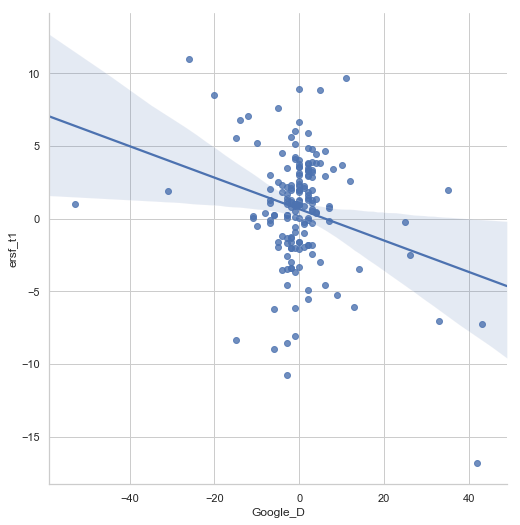

In [5434]:
sns.set_style('whitegrid')
ax = sns.lmplot( x='Google_D', y='ersf_t1', data=df04, fit_reg=True)
ax.fig.set_size_inches(8,8)
plt.show();